# Automatically restart docker containers after reboot
> Creating a cloud server and the service that restarts a web app when rebooted.

- toc: true 
- badges: false
- comments: false
- categories: [systemd, automation]
- show_image: true
- image: images/on.png

# The Problem

As part of Covid-19 relief, DigitalOcean donated some free credit for me to work on a local food delivery scheme.

I need to get most value for money by making that credit go as far as possible. A solution would present another advantage in minimising power consumption.



# The Solution

The server should be powered-down outside of operating hours and turned back on before start of business. This can be done using the cloud provider's control panel.

To avoid manual work to start the web app, a service is needed to bring the containers back online when the droplet is swtiched on.

Covered in this article is the process for using the DigitalOcean API to create a droplet with the requisite `user_data` for creating the `systemd` service to start containers at boot time.

**TLDR; Have a look at the [companion repo.](https://github.com/jonwhittlestone/scheduled-serverless-startup). It contains an example dockerized web app and the shell scripts for starting containers and creating the service.**

Not covered in this article is the process to automate the power down and up to a schedule. This is covered in a subsequent article.


## Prerequisites

* A Digital Ocean account (free trial available)
* [Generate an access token](https://www.digitalocean.com/docs/apis-clis/api/) for accessing the DigitalOcean API
* Add the token to your environment

        $ export DIGITAL_OCEAN_ACCESS_TOKEN=XXXXXXXX
* `jq` installed to format JSON responses
    * [Download JQ](https://stedolan.github.io/jq/download/) for your OS

## Create a DigitalOcean droplet (optional)


If you already have a web server, with an app, move to section, ['Create a systemd service.'](#Create-a-systemd-service)

If you do not already have a web server, launch a Droplet with requisite SSH access.


### CURL to create the droplet

The following CURL statement creates an Ubuntu 18.04 server in London. The `user_data` key in the payload is used for defining various statements to execute once the server is created. In this case we are cloning the repo containing the dockerized app, starting it, and creating the upstart service to restart the app when the server is restarted.

        $ curl -X POST \
        -H 'Content-Type: application/json' \
        -H 'Authorization: Bearer '$DIGITAL_OCEAN_ACCESS_TOKEN'' \
        -d '{"name":"scheduled-serverless","region":"lon1","size":"s-2vcpu-4gb","image":"docker-18-04", "user_data":
        "#!/bin/bash
        apt-get update
        apt-get upgrade -y
        git clone https://github.com/jonwhittlestone/scheduled-serverless-startup.git /root/scheduled-serverless-startup
        sh /root/scheduled-serverless-startup/start-containers.sh
        sh /root/scheduled-serverless-startup/create-service.sh"}' \
        "https://api.digitalocean.com/v2/droplets" 

### SSH into your new droplet

You will be emailed your root password. 
After you SSH in using the provided password, you will be asked to change it.


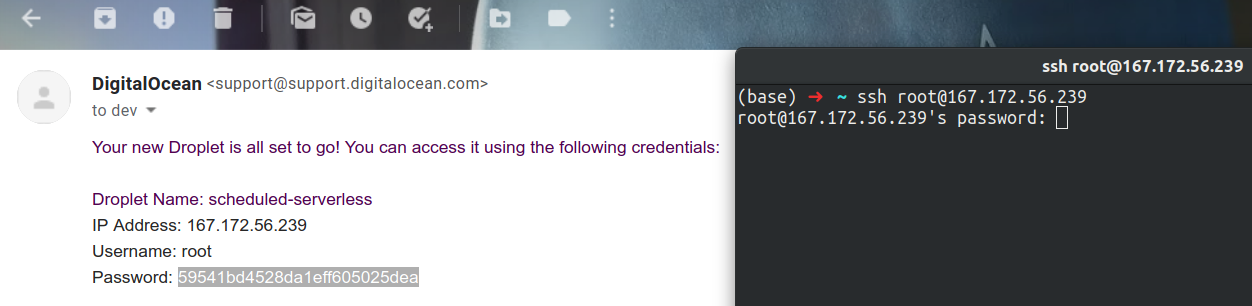

### Test the web app is running

The app is running with Docker on port 80, so it's simply a case of: 
    
    root@scheduled-serverless:~# curl localhost

    A Howapped Project.
    
### Test the service is running

Restart your server with
    
    root@scheduled-serverless:~# sudo reboot
    
And then ssh and repeat the CURL statement to the web service

    (base) ➜  ~ ssh root@167.172.56.239 curl localhost
    root@167.172.56.239's password: 
      % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
      0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
    A Howapped Project.

    100    22  100    22    0     0   1294      0 --:--:-- --:--:-- --:--:--  1294


## Create a systemd service

Ubuntu's init system is called `systemd` and various flavours of Linux may have differing init systems.

### Scripting the starting of the web app

We need to define what should be automated which is starting the containers.

In this case, I have an example dockerized app defined in the companion repo, so let's clone that.

If this directory is present (because it has been previously cloned), then just update the local repo.

```
#!/bin/bash

if [ -d "/root/scheduled-serverless-startup" ] 
then
    git pull origin master
else
    cd /root/scheduled-serverless-startup
     git clone https://github.com/jonwhittlestone/scheduled-serverless-startup.git /root/scheduled-serverless-startup
fi
cd /root/scheduled-serverless-startup/app
docker-compose up -d
```

Lastly, we start containers with `docker-compose`

### Using `systemctl` to enable the service

Using the interface [`systemctl`](https://www.linode.com/docs/quick-answers/linux-essentials/introduction-to-systemctl/) we can manage the init system. Each service is called a unit file. This means loading a service, [enabling at boot](https://www.linode.com/docs/quick-answers/linux-essentials/introduction-to-systemctl/#enabling-a-service-at-boot) and restarting.

On an Ubuntu system, you may inspect the running services:

```
$ systemctl status | head
● madebyjon
    State: running
     Jobs: 0 queued
   Failed: 0 units
    Since: Mon 2020-06-08 05:56:42 BST; 1 day 2h ago
   CGroup: /
           ├─3770 bpfilter_umh
           ├─user.slice
           │ └─user-1000.slice
           │   ├─user@1000.service

```


The following [shell script](https://github.com/jonwhittlestone/scheduled-serverless-startup/blob/master/create-service.sh) creates the unit file, enables it at boot and starts the service.

```
#!/bin/bash
touch /etc/systemd/system/howapped.service
cat > /etc/systemd/system/howapped.service<<-EOF
    [Unit]
    Description=HowappedProjectStartOnBoot
    After=network.target
    [Service]
    Type=simple
    User=root
    WorkingDirectory=/root/scheduled-serverless-startup
    ExecStart=/bin/sh /root/scheduled-serverless-startup/start-containers.sh
    Restart=on-abort
    [Install]
    WantedBy=multi-user.target
EOF
systemctl daemon-reload
systemctl enable howapped.service
systemctl restart howapped.service
```

## Enable the systemd service

The below excerpt verifies we have the working directory created. 


```
root@scheduled-serverless:~/scheduled-serverless-startup# ls
README.md    app                create-service.sh
Vagrantfile  cloud-config.yaml  start-containers.sh
root@scheduled-serverless:~/scheduled-serverless-startup# pwd
/root/scheduled-serverless-startup
```

And this runs the shell script to create the unit file and enable it.

```
root@scheduled-serverless:~/scheduled-serverless-startup# sh create-service.sh 
Created symlink /etc/systemd/system/multi-user.target.wants/howapped.service → /etc/systemd/system/howapped.service.

```


## Test it

We will use the CURL statement to find the ID of our droplet, so that we can then use a CURL statement to power down the machine.

```
$ curl \
        -H 'Content-Type: application/json' \
        -H 'Authorization: Bearer '$DIGITAL_OCEAN_ACCESS_TOKEN'' \
    "https://api.digitalocean.com/v2/droplets?name=scheduled-serverless" | jq '.droplets[] | {id:.id, name:.name, status: .status}'
    
{
  "id": 195393249,
  "name": "scheduled-serverless",
  "status": "on"
}


# power it down
$ curl -X POST \
    -H 'Content-Type: application/json' \
    -H 'Authorization: Bearer '$DIGITAL_OCEAN_ACCESS_TOKEN'' \
    -d '{"type":"power_off"}' \
    "https://api.digitalocean.com/v2/droplets/195393249/actions" | jq '.[] | {id:.id, status:.status, type:.type}'

```

We power it back up:

```
$ curl -X POST \
    -H 'Content-Type: application/json' \
    -H 'Authorization: Bearer '$DIGITAL_OCEAN_ACCESS_TOKEN'' \
    -d '{"type":"power_on"}' \
    "https://api.digitalocean.com/v2/droplets/195393249/actions" | jq '.[] | {id:.id, status:.status, type:.type}'

{
  "id": 953153688,
  "status": "in-progress",
  "type": "power_on"
}

```


And verify our app is running.

```
$ ssh root@104.248.174.117 curl localhost
root@104.248.174.117's password: 
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
A Howapped Project.

```

## Clean up

If you were following along by creating a DigitalOcean droplet, you may wish to power down or destroy the machine if not in use.

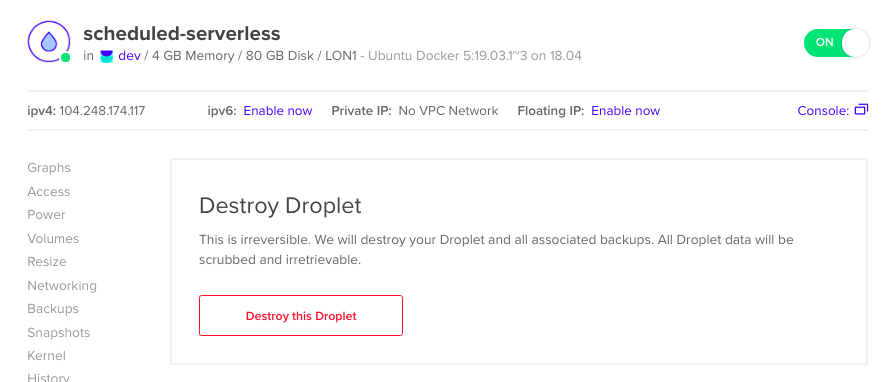

## Resources

* [Linode - Introduction to Systemctl](https://www.linode.com/docs/quick-answers/linux-essentials/introduction-to-systemctl/)